# Using `IN_LEAGUE_NEXT` as our response variable

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load/inspect the data

In [97]:
df = pd.read_csv("Data/merged_data/merged_data_collapsed_teams.csv").dropna() #drop NAN rows

In [99]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'TEAMS_LIST', 'PLAYER_AGE',
       'EXPERIENCE', 'POS', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR',
       'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT',
       'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS',
       'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary',
       'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST',
       'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF',
       'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG',
       'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG',
       'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG',
       'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF',
       'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR'

In [101]:
#grab all columns as a list
all_columns = list(df.columns)

#grab just the numerical features
features = [all_columns[2]] + all_columns[4:6] + all_columns[7:]

## Compute correlations

In [104]:
corr = df[features].corr()

In [106]:
corr["IN_LEAGUE_NEXT"]

SEASON_START             -0.150368
PLAYER_AGE               -0.090205
EXPERIENCE               -0.023300
GP                        0.445148
GS                        0.296357
MIN                       0.402708
FGM                       0.332489
FGA                       0.337437
FG_PCT                    0.179278
FG3M                      0.174645
FG3A                      0.181073
FG3_PCT                   0.107803
FTM                       0.287988
FTA                       0.298033
FT_PCT                    0.223487
OREB                      0.281000
DREB                      0.323175
REB                       0.321762
AST                       0.246663
STL                       0.332586
BLK                       0.216754
TOV                       0.339693
PF                        0.411087
PTS                       0.327447
PER                       0.252143
TS_PERCENT                0.198701
X3P_AR                   -0.081465
F_TR                      0.026925
ORB_PERCENT         

In [108]:
#Note that ~81% of players have IN_LEAGUE_NEXT = 1, so we have imbalanced classes 
df.IN_LEAGUE_NEXT.value_counts(normalize=True)

IN_LEAGUE_NEXT
1.0    0.805443
0.0    0.194557
Name: proportion, dtype: float64

# Training a simple classifier

We can see that `IN_LEAGUE_NEXT` is potentially a good response variable for two reasons:
- it has reasonably high correlations with the predictor data (with, e.g., `GP`, `PF`, `PCT_TEAM_SALARY`)
- it describes the future state of a player, so predicting it using just current-season stats data is interesting.

Predicting whether or not a player is in the league next year is also reasonably interesting, and training an interpretable model (like the logistic regression model below) can give us some hints as to what fringe NBA players could do to increase their odds of staying in the league.

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

In [148]:
#let's be careful here: some of the columns in the dataframe include future data.  Let's just use
#current-season stats data
predictors = features[0:46]

print(predictors)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary']


In [150]:
#make train-test split
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df.IN_LEAGUE_NEXT, 
                                                    test_size=0.1, random_state=5, shuffle=True, stratify=df.IN_LEAGUE_NEXT.values)

In [152]:
#oversample the rare class (waived players)
from imblearn.over_sampling import SMOTE, RandomOverSampler

#it seems like SMOTE (generating synthetic data for players with IN_LEAGUE_NEXT=0) works better than
#randomly oversampling
smote = SMOTE(random_state=512)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#ros = RandomOverSampler(random_state=5)
#X_train_re, y_train_re = ros.fit_resample(X_train, y_train)

Accuracy:    0.84
Precision:   0.92
Recall:      0.88
NPV:         0.58
Specificity: 0.67


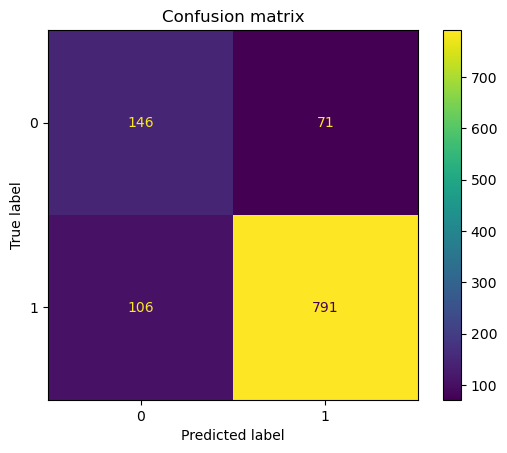

In [154]:
lr = Pipeline([("scale", StandardScaler()), ("log_reg", LogisticRegression(penalty=None, max_iter=10_000))])
lr.fit(X_train_re, y_train_re)
preds    = lr.predict(X_test)

accuracy  = accuracy_score(y_test, preds)
conf      = confusion_matrix(y_test, preds)
#grab true negatives, true positives, false positives, false negatives
tn = conf[0,0]
tp = conf[1,1]
fp = conf[0,1]
fn = conf[1,0]

#precision (positive predictive value): what % of players classified as 1's are true 1's?
precision   = tp/(tp+fp)
#recall (sensitivity): what % of true 1's are classified as 1?
recall      = tp/(tp+fn)
#negative predictive value (NPV): what % of players classified as 0's are true 0's?
npv         = tn/(tn+fn)
#specificity: what % of true 0's are classified as 0?
specificity = tn/(tn+fp)

print(f"Accuracy:    {accuracy:.2f}")
print(f"Precision:   {precision:.2f}")
print(f"Recall:      {recall:.2f}")
print(f"NPV:         {npv:.2f}")
print(f"Specificity: {specificity:.2f}")

ConfusionMatrixDisplay(conf).plot()
plt.title("Confusion matrix")
plt.show()

To briefly summarize: the performance is reasonably good.  The classifier is really good ($\sim 90\%$ precision and recall) at correctly guessing when a player will stay in the league (which is the majority class, about $81\%$ of all rows), and a bit better than random chance when a player is going to be out of the league ($\sim 60\%$ recall and NPV).

Note that we only used stats and salary data!  We could also include predictors like draft position if a player was drafted and whether or not a player has been previously traded or waived.  To see which additional predictors could be useful, we need to **look at the false positives and false negatives** to see why our model is guessing wrong.

## Investigating FPs and FNs

Let's add a row to `df` with the model's prediction.  Then we can consider false positives and false negatives, and see why they get misclassified.

In [158]:
df["MODEL_PRED"] = lr.predict(df[predictors])

In [160]:
df.loc[ (df["IN_LEAGUE_NEXT"]==1) & (df["MODEL_PRED"]==0) ].sample(3)

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,MODEL_PRED
15723,Quenton Jackson,1631245,2022,['WAS'],24.0,1,PG,9,0.0,135.0,19,42,0.452,1.0,12.0,0.083,17,22,0.773,2.0,6.0,8.0,15,4.0,1.0,4.0,10,56,12.2,0.542,0.286,0.524,1.7,4.8,3.3,15.1,1.4,0.6,7.2,17.9,0.1,0.1,0.2,0.078,-3.7,-1.5,-5.2,-0.1,169630.0,0.001116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10929,AJ Price,201985,2013,['MIN'],27.0,5,SG,28,0.0,99.0,19,46,0.413,6.0,22.0,0.273,0,2,0.000,1.0,9.0,10.0,13,1.0,0.0,7.0,5,44,9.7,0.469,0.478,0.043,1.1,10.2,5.5,21.5,0.5,0.0,13.0,23.2,-0.1,0.0,0.0,-0.012,-2.4,-2.4,-4.8,-0.1,947907.0,0.013825,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12181,Pablo Prigioni,203143,2012,['NYK'],36.0,1,PG,78,18.0,1263.0,100,220,0.455,53.0,134.0,0.396,22,25,0.880,41.0,102.0,143.0,236,69.0,2.0,86.0,127,275,13.0,0.595,0.609,0.114,3.7,9.8,6.6,27.5,2.9,0.1,27.1,11.7,2.0,1.3,3.2,0.123,-0.8,0.9,0.1,0.7,473604.0,0.005922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [175]:
#TODO: add position data
#pd.get_dummies(df, columns=["POS"])